In [1]:
import numpy as np
import cv2
import sys
import time
import pandas as pd
from pyntcloud import PyntCloud as pc
from pylibfreenect2 import Freenect2, SyncMultiFrameListener
from pylibfreenect2 import FrameType, Registration, Frame
from pylibfreenect2 import createConsoleLogger, setGlobalLogger
from pylibfreenect2 import LoggerLevel
import matplotlib.pyplot as plt

In [2]:
try:
    from pylibfreenect2 import OpenGLPacketPipeline
    pipeline = OpenGLPacketPipeline()
except:
    try:
        from pylibfreenect2 import OpenCLPacketPipeline
        pipeline = OpenCLPacketPipeline()
    except:
        from pylibfreenect2 import CpuPacketPipeline
        pipeline = CpuPacketPipeline()
print("Packet pipeline:", type(pipeline).__name__)

Packet pipeline: OpenCLPacketPipeline


In [3]:
fn = Freenect2()
num_devices = fn.enumerateDevices()
print("Number of devices: {}".format(num_devices))

Number of devices: 1


In [4]:
serial = fn.getDeviceSerialNumber(0)
device = fn.openDevice(serial, pipeline=pipeline)

In [5]:
listener = SyncMultiFrameListener(FrameType.Color | FrameType.Ir | FrameType.Depth)

In [6]:
device.setColorFrameListener(listener)
device.setIrAndDepthFrameListener(listener)

In [7]:
device.start()

In [8]:
registration = Registration(device.getIrCameraParams(),
                            device.getColorCameraParams())

undistorted = Frame(512, 424, 4)
registered = Frame(512, 424, 4)

In [9]:
params = device.getColorCameraParams()
params_ir = device.getIrCameraParams()

In [10]:
# Optinal parameters for registration
# set True if you need
need_bigdepth = False
need_color_depth_map = False

In [11]:
bigdepth = Frame(1920, 1082, 4) if need_bigdepth else None
color_depth_map = np.zeros((424, 512),  np.int32).ravel() if need_color_depth_map else None

In [12]:
frames = listener.waitForNewFrame()

color = frames["color"]
ir = frames["ir"]
depth = frames["depth"]

registration.apply(color, depth, undistorted, registered,
                   bigdepth=bigdepth,
                   color_depth_map=color_depth_map)

In [13]:
device.stop()
device.close()

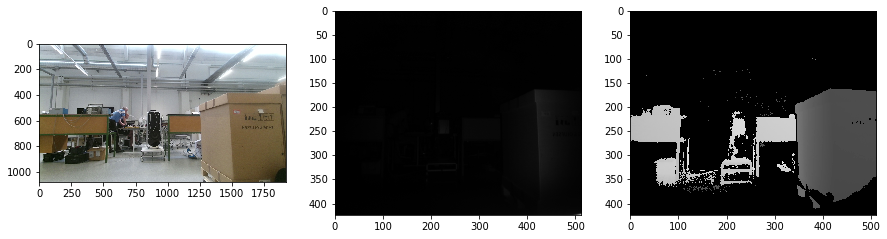

In [14]:
f, subs = plt.subplots(1, 3, figsize=(15, 8))
subs[0].imshow(cv2.cvtColor(color.asarray(), cv2.COLOR_BGR2RGB))
subs[1].imshow(ir.asarray(), cmap='gray')
subs[2].imshow(depth.asarray(), cmap='gray')

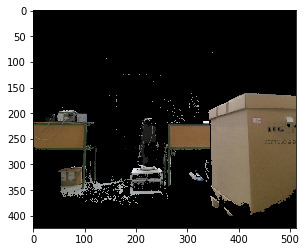

In [15]:
reg = registered.asarray(np.uint8)
color_image = cv2.cvtColor(reg, cv2.COLOR_BGR2RGB)
depth_image = depth.asarray()
plt.imshow(color_image)

In [16]:
Depth_ResX, Depth_ResY = depth_image.shape

In [17]:
print("Depth cx: {}".format(params.cx))
print("Depth cy: {}".format(params.cy))
print("Depth fx: {}".format(params.fx))
print("Depth fy: {}".format(params.fy))

Depth cx: 959.5
Depth cy: 539.5
Depth fx: 1081.3720703125
Depth fy: 1081.3720703125


In [18]:
print("IR cx: {}".format(params_ir.cx))
print("IR cy: {}".format(params_ir.cy))
print("IR fx: {}".format(params_ir.fx))
print("IR fy: {}".format(params_ir.fy))

IR cx: 258.14471435546875
IR cy: 211.92750549316406
IR fx: 365.9132080078125
IR fy: 365.9132080078125


In [19]:
index_x = np.tile(np.arange(0, Depth_ResY), (Depth_ResX, 1))
index_y = np.tile(np.arange(0, Depth_ResX), (Depth_ResY, 1)).T
print(index_x.shape)
print(index_y.shape)

(424, 512)
(424, 512)


In [20]:
valid_rgb = color_image[depth_image != 0.0]
print(valid_rgb.shape)

(54384, 3)


In [21]:
before = time.time()

valid_points = np.count_nonzero(depth_image != 0.0)
valid_rgb = color_image[depth_image != 0.0]

valid_depth = depth_image[depth_image != 0.0] / 256.0
valid_x = valid_depth * (index_x[depth_image != 0.0] - params_ir.cx) / params_ir.fy
valid_y = valid_depth * (index_y[depth_image != 0.0] - params_ir.cy) / params_ir.fx


point_cloud = np.zeros((valid_points, 6))
point_cloud[:,0] = valid_x
point_cloud[:,1] = valid_y
point_cloud[:,2] = valid_depth
point_cloud[:,3:] = valid_rgb

after = time.time()
print("Execution time: {}".format(after-before))

Execution time: 0.006558418273925781


In [22]:
points = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points.describe()

,x,y,z,red,green,blue
count,54384.000000,54384.000000,54384.000000,54384.000000,54384.000000,54384.000000
mean,0.262966,1.402006,8.577746,117.128880,101.740126,78.178858
std,3.786839,1.420261,3.945277,38.374597,35.187200,38.450286
min,-9.082657,-9.701303,2.589142,0.000000,0.000000,0.000000
25%,-1.269880,0.376227,5.252007,106.000000,86.000000,52.000000
50%,2.137608,1.199391,6.072030,122.000000,97.000000,66.000000
75%,2.678897,2.001503,13.261478,143.000000,129.000000,106.000000
max,5.990099,5.676936,17.576956,255.000000,255.000000,255.000000


In [23]:
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700))